# Scanpy: Trajectory inference for hematopoiesis in mouse
[Scanpy tutorials](https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html)

Reconstructing myeloid and erythroid differentiation for data of [Paul et al. (2015)](https://www.sciencedirect.com/science/article/pii/S0092867415014932?via%3Dihub).

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                 9.5.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
colorama            0.4.6
comm                0.1.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
executing           1.2.0
h5py                3.7.0
hypergeom_ufunc     NA
igraph              0.10.4
invgauss_ufunc      NA
ipykernel           6.23.1
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
llvmlite            0.40.0
matplotlib          3.7.1
mkl                 2.4.0
mpl_toolkits        NA
natsort             8.3.1
nbinom_ufunc        NA
ncf_ufunc           NA
nct_ufunc           NA
ncx2_ufunc          NA
numba               0.57.0
numpy               1.24.3
packaging           23.0
pandas              1.5.3
parso           

In [3]:
adata = sc.datasets.paul15()

100%|██████████| 9.82M/9.82M [00:02<00:00, 4.85MB/s]
/Users/liaoyj/mambaforge/envs/scanpy/lib/python3.10/site-packages/scanpy/datasets/_datasets.py:202: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['iroot'] = 840


In [4]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

## Preprocessing + Visualization

Apply [preprocessing recipe](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.recipe_zheng17.html) reproducing the normalization, filtering, preprocessing of [Zheng et al. 2017](https://www.nature.com/articles/ncomms14049)

In [5]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)


In [6]:
sc.tl.pca(adata, svd_solver='arpack') # PCA

computing PCA
    with n_comps=50
    finished (0:00:00)


In [8]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:09)


/Users/liaoyj/mambaforge/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


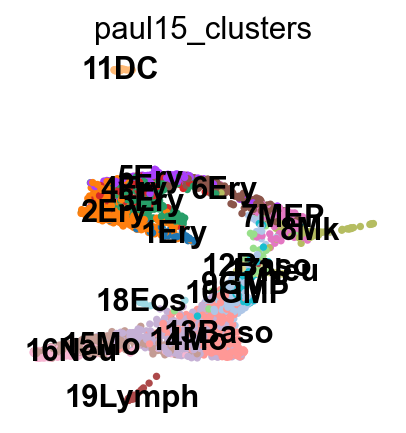

In [9]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

## Optional: Denoising graph

- represent it in diffusion map space (not PCA space)
- computing distances within a few diffusion components amounts to denoising the graph
    - take a few of the first spectral components
- similar to denoising data mtx using PCA
- approach used in papers
    - [Schiebinger et al. 2019](https://www.sciencedirect.com/science/article/pii/S009286741930039X?via%3Dihub)
    - [Tabaka et al. 2019](https://www.biorxiv.org/content/10.1101/512582v1)
    - [Dijk et al. 2018 MAGIC](https://www.sciencedirect.com/science/article/pii/S0092867418307244?via%3Dihub)
- NOT a necessary step - can proceed w/ non-denoised graph

In [10]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989645  0.99678516 0.9944012  0.9892853
     0.98826355 0.9871257  0.98383176 0.98297554 0.9789324  0.9768993
     0.97440904 0.9727858  0.9661875 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [11]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:08)


/Users/liaoyj/mambaforge/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


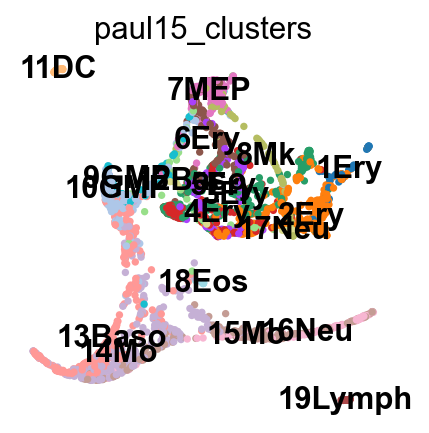

In [12]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

## Clustering and PAGA

In [1]:
# Leiden preferred for modern analysis, but louvain for replicating paper
sc.tl.louvain(adata, resolution=1.0)

NameError: name 'sc' is not defined

Annotate clusters w/ marker genes

cell type	marker
HSCs	Procr
Erythroids	Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1
Neutrophils	Elane, Cebpe, Ctsg, Mpo, Gfi1
Monocytes	Irf8, Csf1r, Ctsg, Mpo
Megakaryocytes	Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf
Basophils	Mcpt8, Prss34
B cells	Cd19, Vpreb2, Cd79a
Mast cells	Cma1, Gzmb, CD117/C-Kit
Mast cells & Basophils	Ms4a2, Fcer1a, Cpa3, CD203c (human)

Simple coarse-grained visualization -> compute PAGA graph, a coarse-grained and simplified (abstracted) graph
- non-significant edges in coarse-grained graph thresholded out

In [15]:
sc.tl.paga(adata, groups='louvain')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


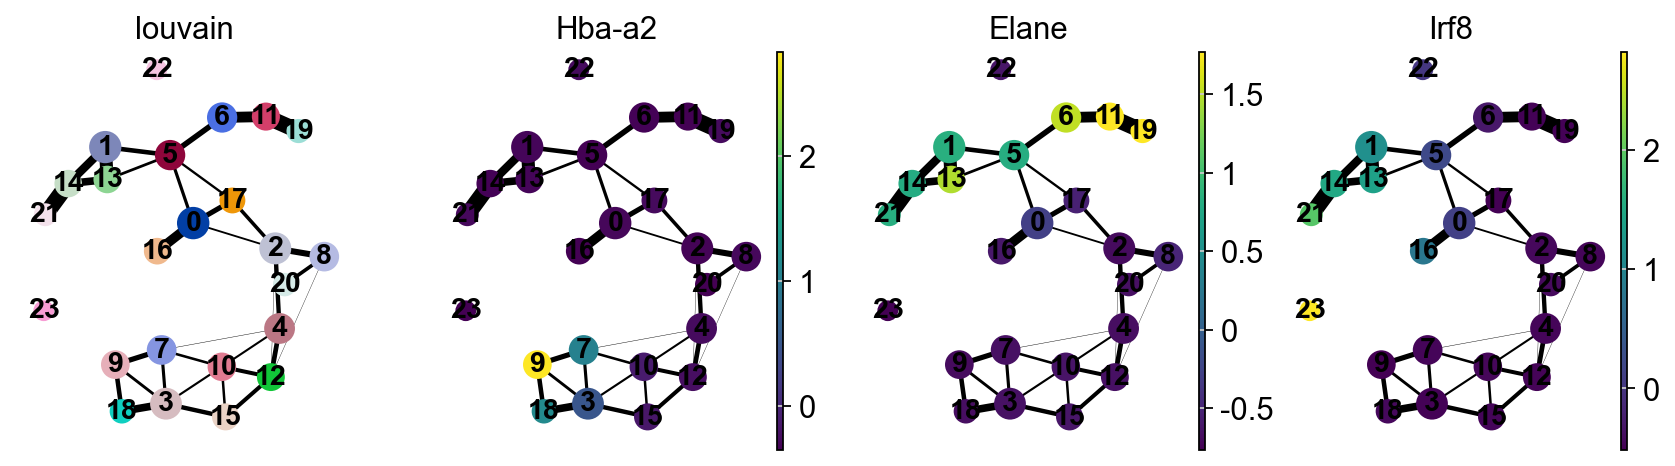

In [16]:
sc.pl.paga(adata, color=['louvain', 'Hba-a2', 'Elane', 'Irf8'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


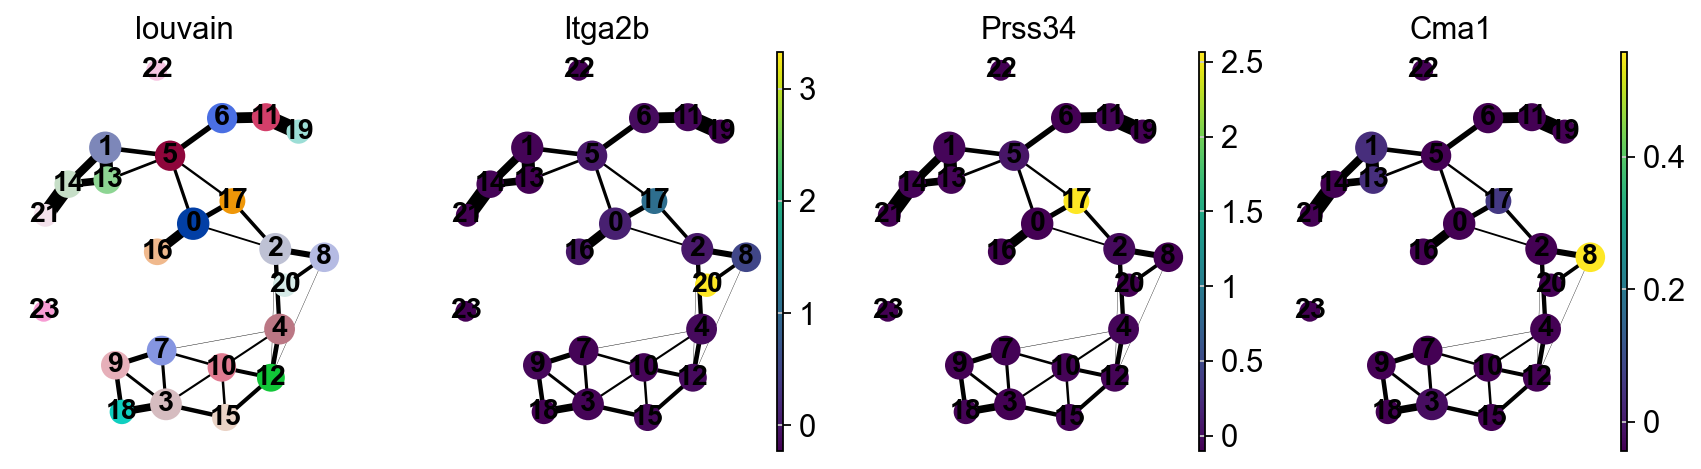

In [17]:
sc.pl.paga(adata, color=['louvain', 'Itga2b', 'Prss34', 'Cma1'])

Actually annotate the clusters
- Cma1 is a Mast cell marker, only appears in small fraction of cells in the progenitor/stem cell cluster 8

In [18]:
adata.obs['louvain'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'],
      dtype='object')

In [19]:
adata.obs['louvain_anno'] = adata.obs['louvain']

In [20]:
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10/Ery', '11', '12',
       '13', '14', '15', '16/Stem', '17', '18', '19/Neu', '20/Mk', '21', '22/Baso', '23', '24/Mo']

/var/folders/1x/m4ggj1m11vjgglnbfgvq2g9w0000gv/T/ipykernel_24846/4019411155.py:1: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10/Ery', '11', '12',


ValueError: new categories need to have the same number of items as the old categories!

## Recomputing the embedding using PAGA-initialization

In [21]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:08)


/Users/liaoyj/mambaforge/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


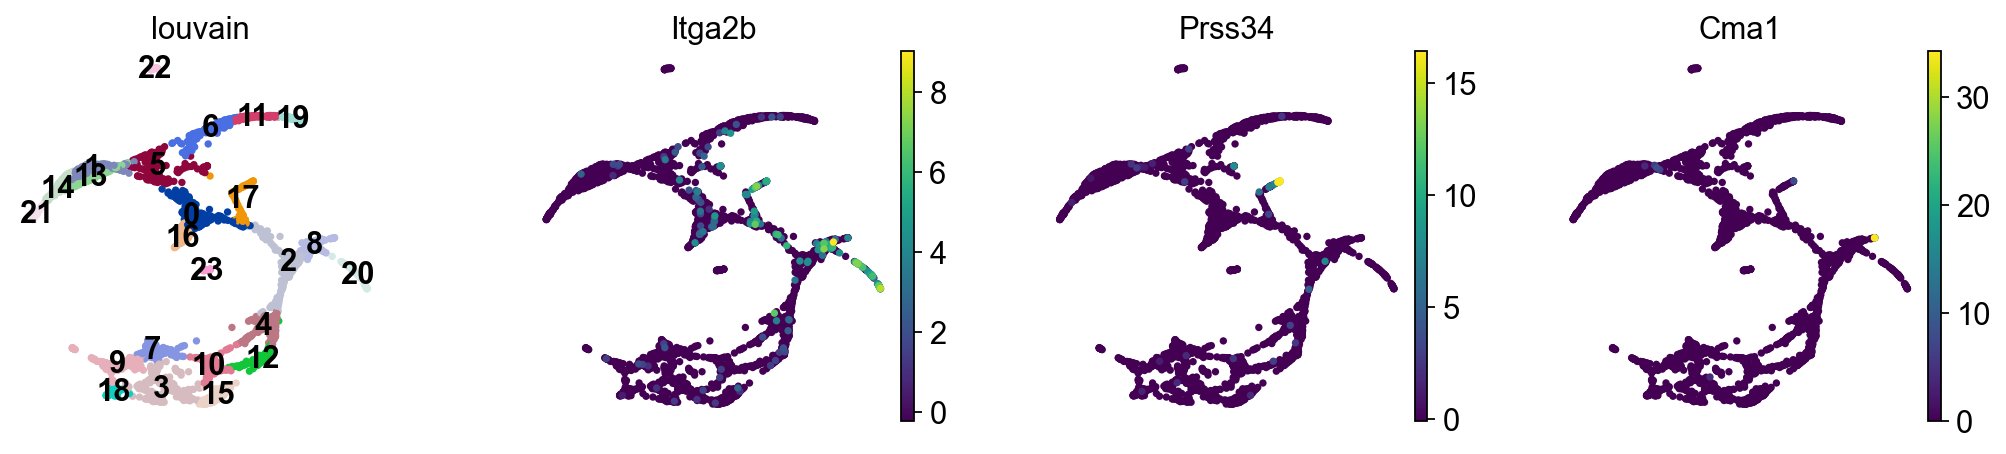

In [23]:
# Can see single-cell resolution in meaningful layout
sc.pl.draw_graph(adata, color=['louvain', 'Itga2b', 'Prss34', 'Cma1'], legend_loc='on data')

/Users/liaoyj/mambaforge/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


--> added 'pos', the PAGA positions (adata.uns['paga'])


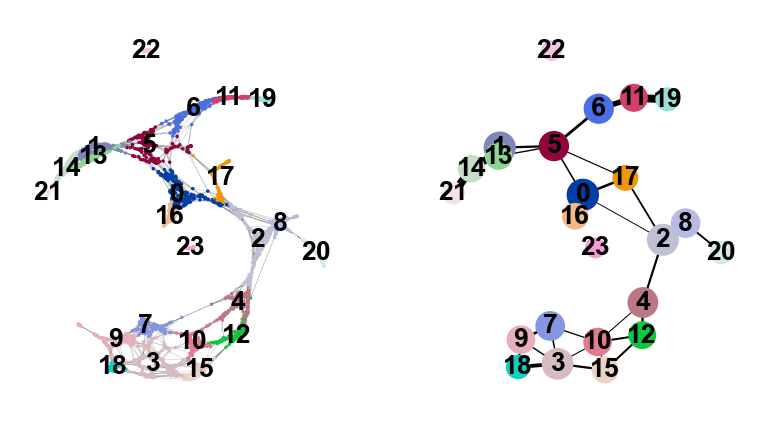

In [29]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

## Reconstructing gene changes along PAGA paths for a given set of genes

In [30]:
# Choose root cell for diffusion pseudotime
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain']  == '2')[0]

In [31]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [32]:
# Select some of the marker gene names
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

In [33]:
# Use full raw data for visualization
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

/Users/liaoyj/mambaforge/envs/scanpy/lib/python3.10/site-packages/scanpy/datasets/_datasets.py:202: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['iroot'] = 840


/Users/liaoyj/mambaforge/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


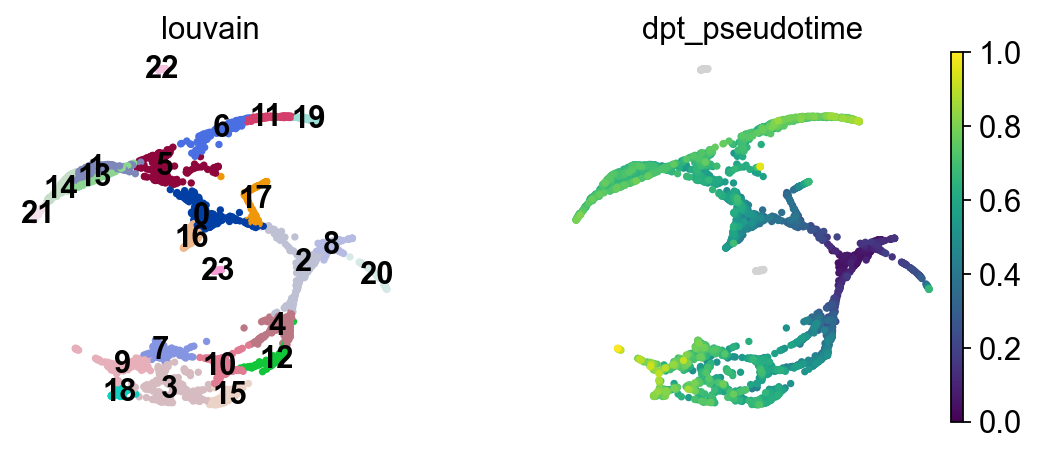

In [34]:
sc.pl.draw_graph(adata, color=['louvain', 'dpt_pseudotime'], legend_loc='on data')

In [35]:
paths = [('erythrocytes', [16, 12, 7, 13, 18, 6, 5, 10]),
         ('neutrophils', [16, 0, 4, 2, 14, 19]),
         ('monocytes', [16, 0, 4, 11, 1, 9, 24])]

In [36]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [37]:
adata.obs['clusters'] = adata.obs['louvain']  # just a cosmetic change

In [46]:
adata.uns['clusters_colors'] = adata.uns['louvain_colors'][0:23]

/Users/liaoyj/mambaforge/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1229: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/Users/liaoyj/mambaforge/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1276: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


IndexError: index 24 is out of bounds for axis 0 with size 24

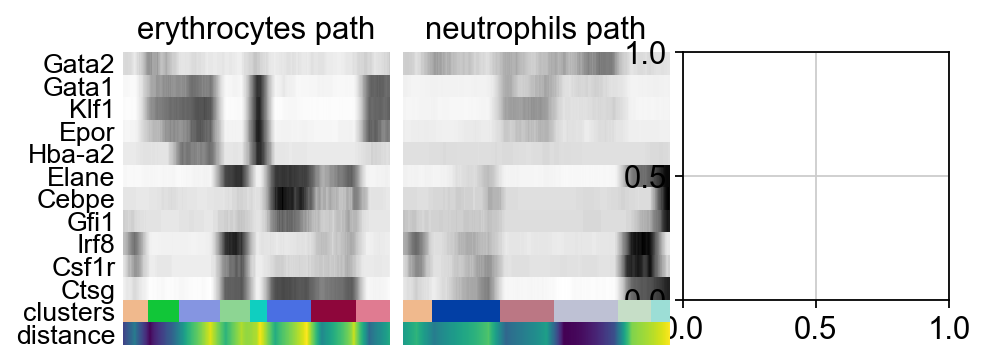

In [47]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('/Users/liaoyj/Documents/Rubalind/data/write/paga_path_{}.csv'.format(descr))
pl.savefig('/Users/liaoyj/Documents/Rubalind/data/figures/paga_path_paul15.pdf')
pl.show()